# U.S. Labor Market Analysis (2000–2024)
This project utilizes the **FRED API** to analyze key labor market indicators across U.S. states from 2000 to 2024. It explores the **S&P 500 Index**, **unemployment rates**, and **labor force participation rates**, offering a comprehensive view of economic conditions and workforce engagement in different states.

## U.S. Labor Market Analysis (2000–2024)
This project utilizes the **FRED API** to analyze key labor market indicators across U.S. states from 2000 to 2024. It explores the **S&P 500 Index**, **unemployment rates**, and **labor force participation rates**, offering a comprehensive view of economic conditions and workforce engagement in different states.


## Setup: Installing and Importing Required Libraries

In [ ]:
# Install required packages
!pip install matplotlib pandas numpy plotly fredapi
!pip install jupyter nbformat

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
import os
from fredapi import Fred

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Connect to FRED API

In [ ]:
# Set up FRED API key
fred_key = 'fred_api_key'

In [5]:
fred = Fred(api_key=fred_key)

## S&P 500 Index Trend

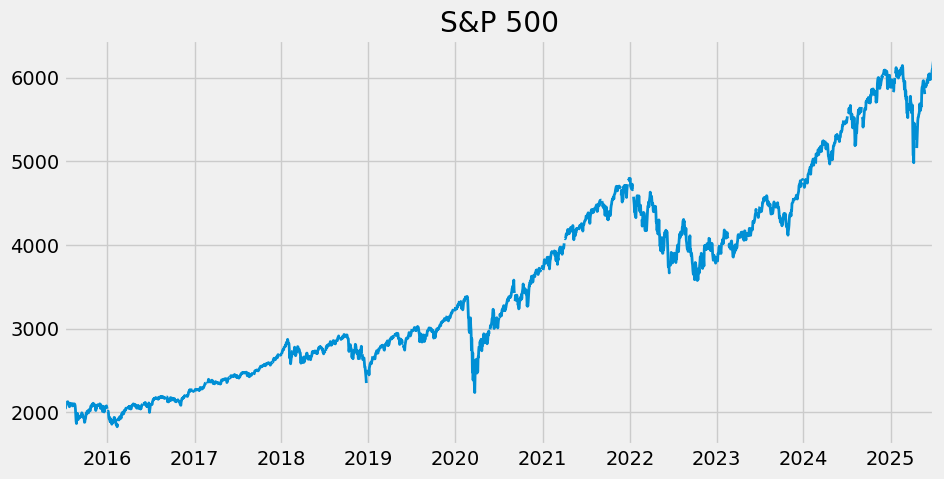

In [6]:
# Search and fetch S&P 500 data
sp_search = fred.search('S&P', order_by='popularity')
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

## State-Level Unemployment Analysis (2000–2024)

In [7]:
# Retrieve unemployment data
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

all_results = []
for myid in unemp_df.index:
    results = fred.get_series(myid).to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)

uemp_results = pd.concat(all_results, axis=1)

# Drop non-state columns
cols_to_drop = [i for i in uemp_results if len(i) > 4]
uemp_results = uemp_results.drop(columns=cols_to_drop)

# Rename columns
uemp_states = uemp_results.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

### Top 10 States with Highest Average Unemployment (2000–2024)

In [7]:
filtered_uemp = uemp_states.loc[(uemp_states.index >= '2000-01-01') & (uemp_states.index <= '2024-12-31')]
avg_unemp = filtered_uemp.mean().sort_values(ascending=False)
top10_states = avg_unemp.head(10).index

fig = px.line(filtered_uemp[top10_states], title='Top 10 States with Highest Average Unemployment (2000–2024)')
fig.show()

### Unemployment Snapshot – December 2024

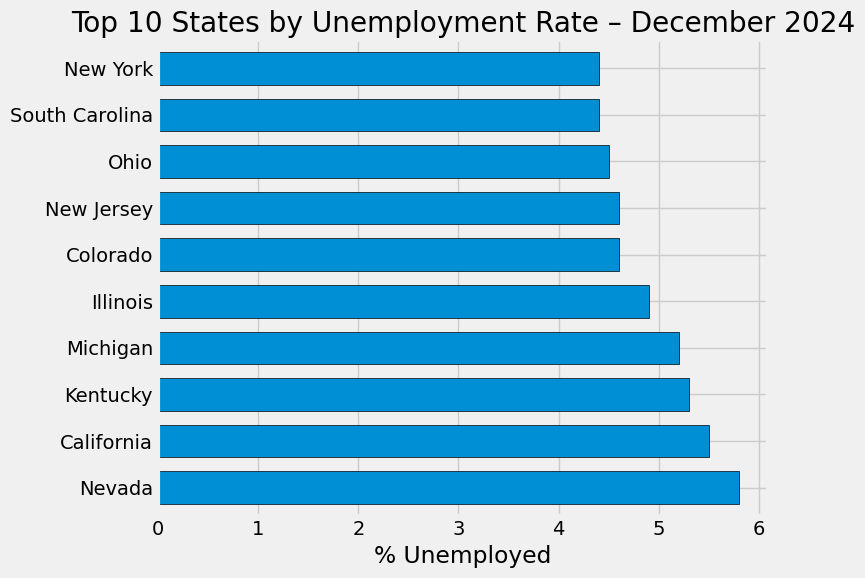

In [8]:
dec_2024 = uemp_states.loc[uemp_states.index == '2024-12-01'].T
top10_dec_2024 = dec_2024.sort_values('2024-12-01', ascending=False).head(10)
ax = top10_dec_2024.plot(kind='barh', figsize=(8, 6), width=0.7, edgecolor='black',
                         title='Top 10 States by Unemployment Rate – December 2024')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.tight_layout()
plt.show()

## Labor Force Participation Rates by State (2020–2024)

In [8]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

all_results = []
for myid in part_df.index:
    results = fred.get_series(myid).to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## State-Wise Comparison: Unemployment vs Participation (2020–2024)

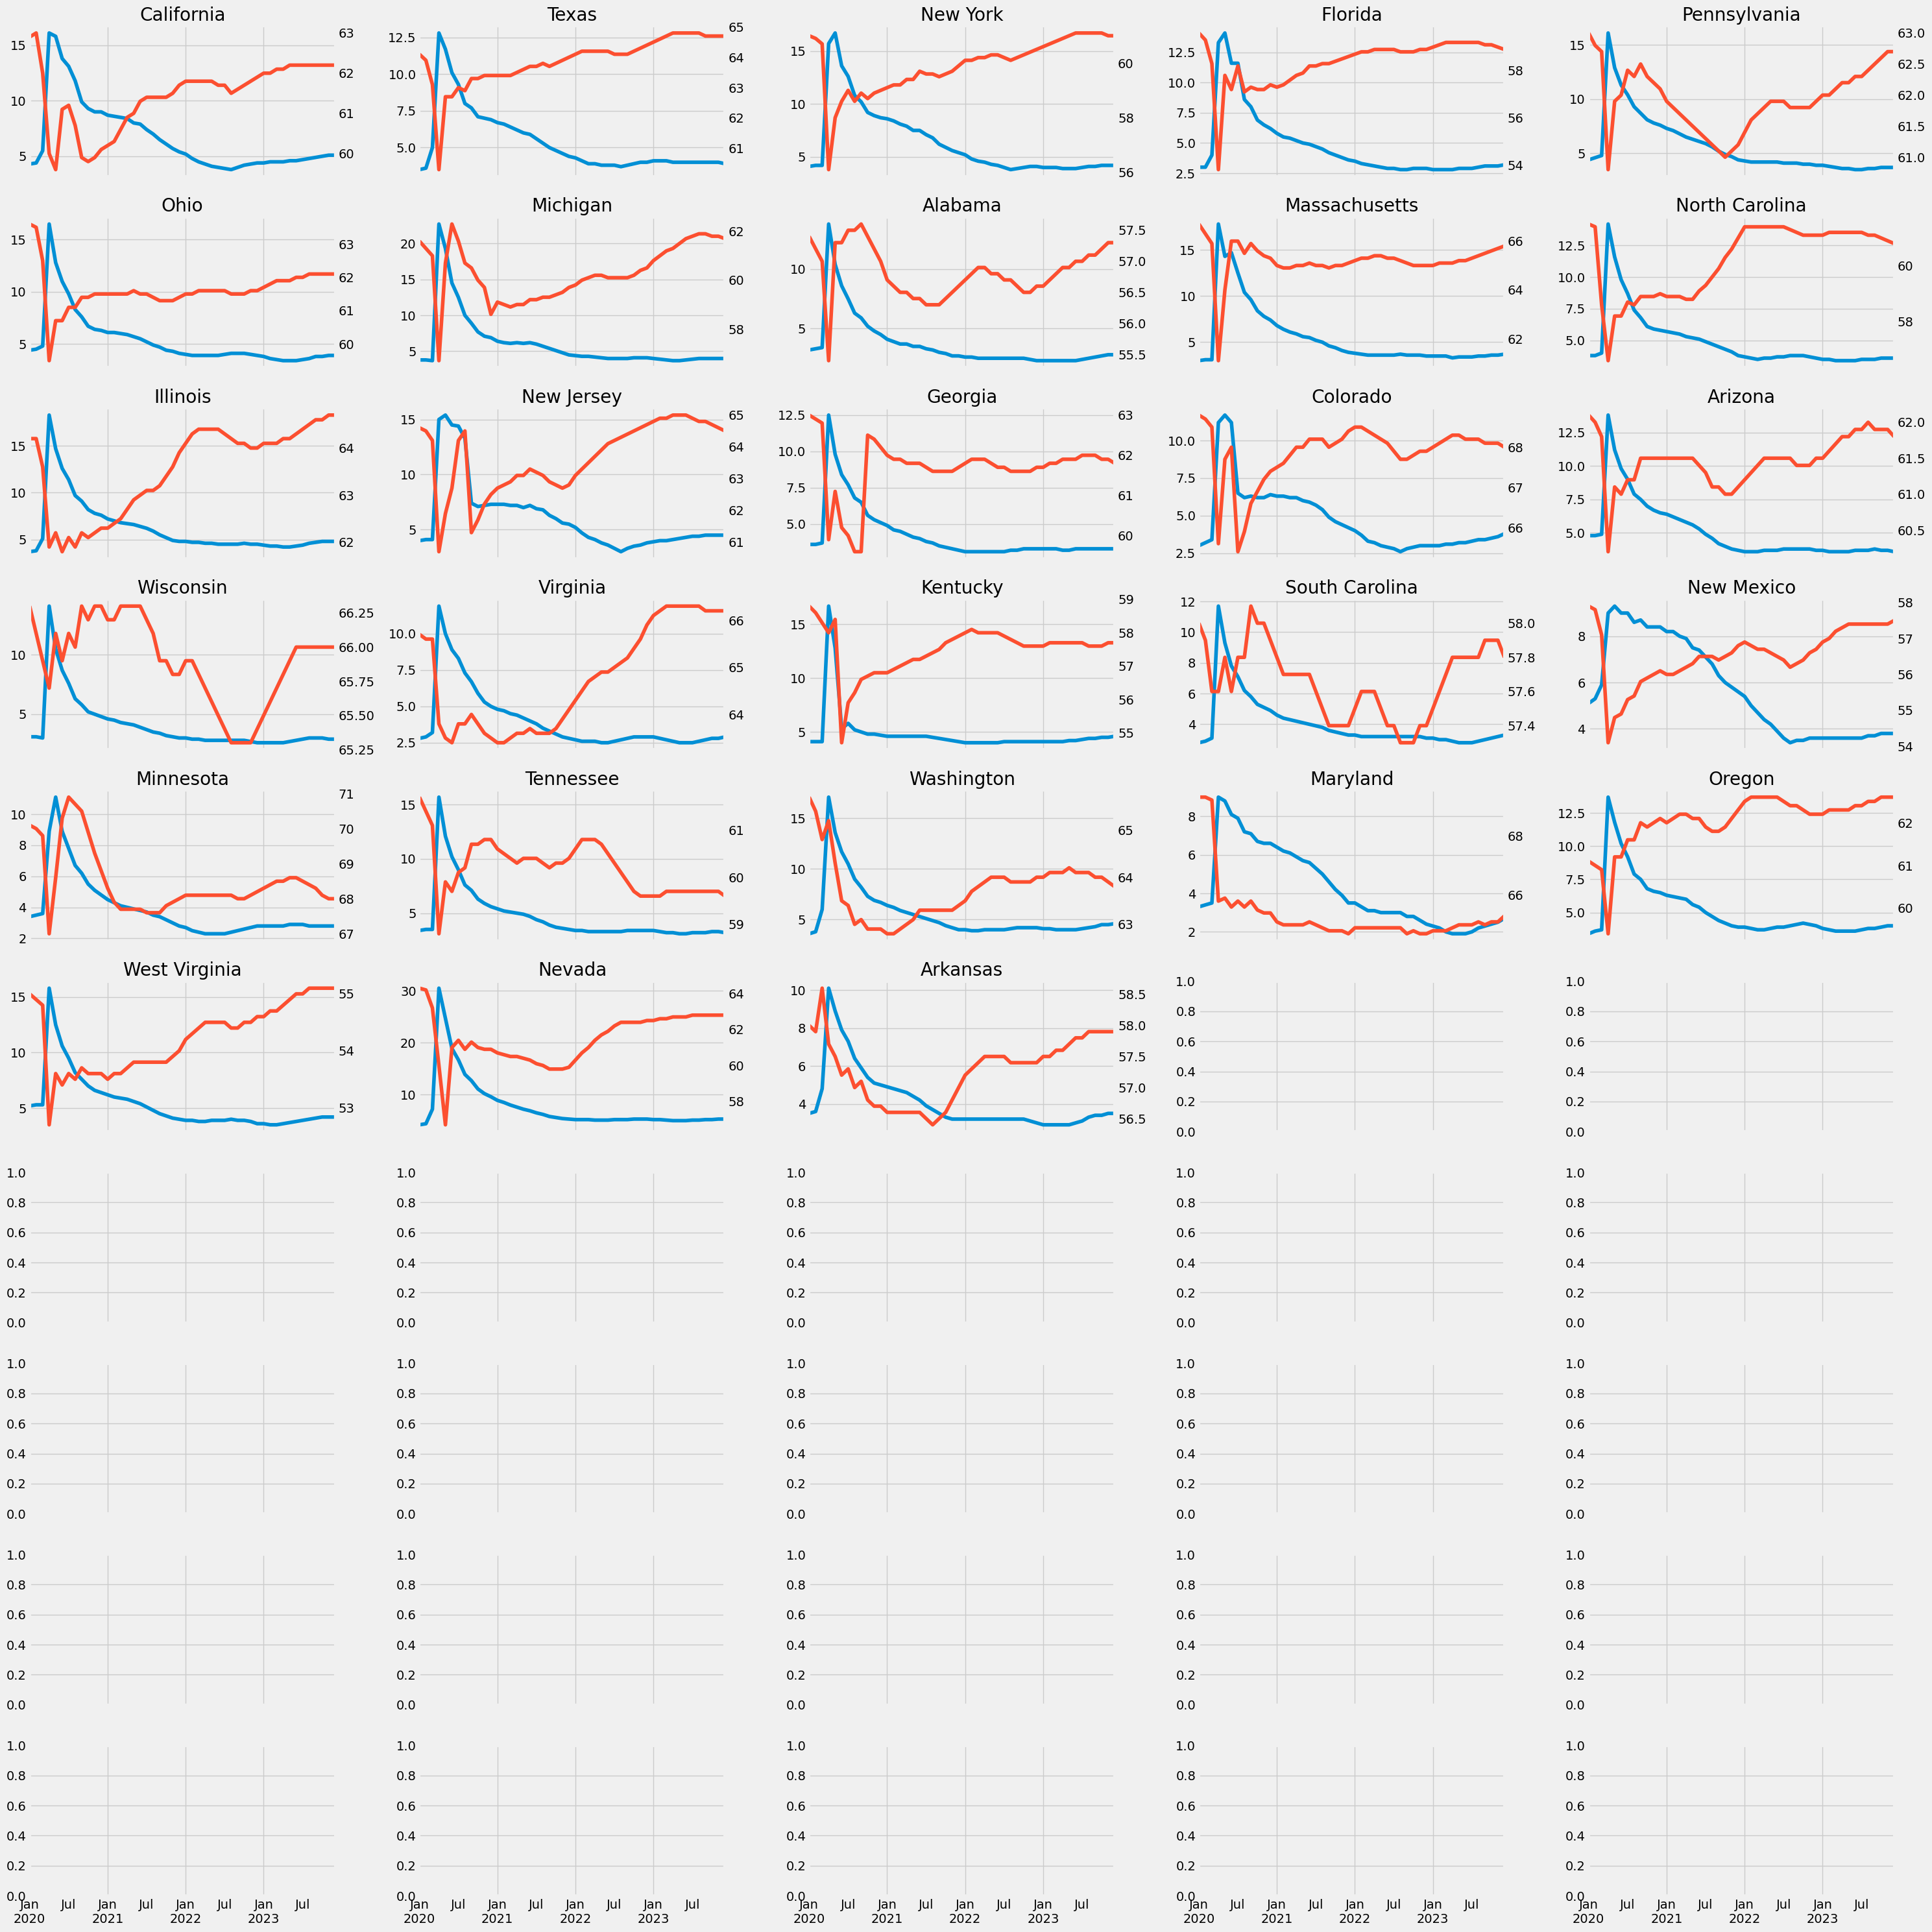

In [10]:
uemp_states = uemp_states.rename(columns={'the District of Columbia': 'District Of Columbia'})

fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia", "Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2024')[state].plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2024')[state].plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

## In-Depth: California's Labor Market (2020–2024)

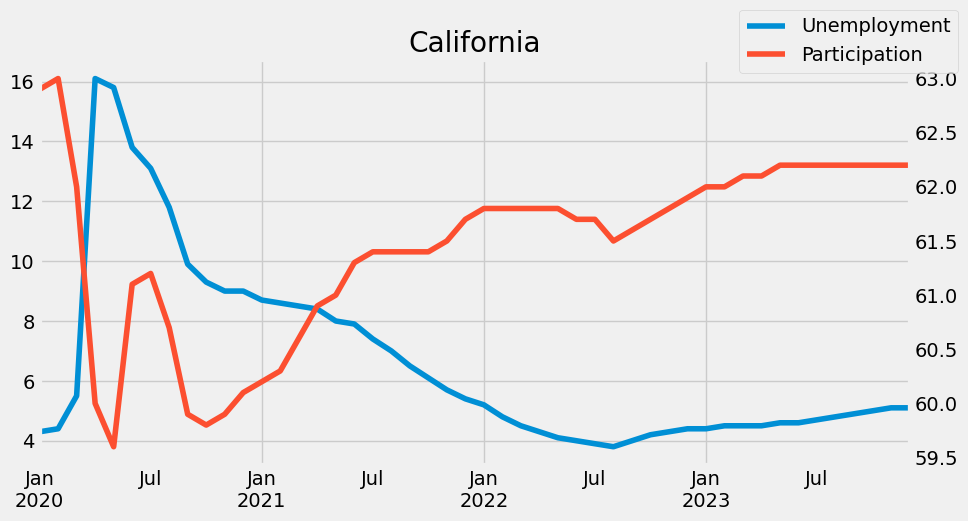

In [9]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2024')[state].plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2024')[state].plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment', 'Participation'])
plt.show()

## Time Series Forecasting: California Unemployment Rate

In this section, we apply time series forecasting techniques to model and predict California's unemployment rate. The forecasting process follows a structured approach, including exploratory analysis, pre-modelling diagnostics, ARIMA model selection, and forecast visualization.


In [10]:
state = 'California'

# Ensure datetime index
uemp_states.index = pd.to_datetime(uemp_states.index)

# Extract California unemployment data
ca_data = uemp_states[state].dropna()

# Reset index for plotting/forecasting
ca_df = ca_data.reset_index()
ca_df.columns = ['Date', 'Unemployment']


C:\Users\Maryam Daniyal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


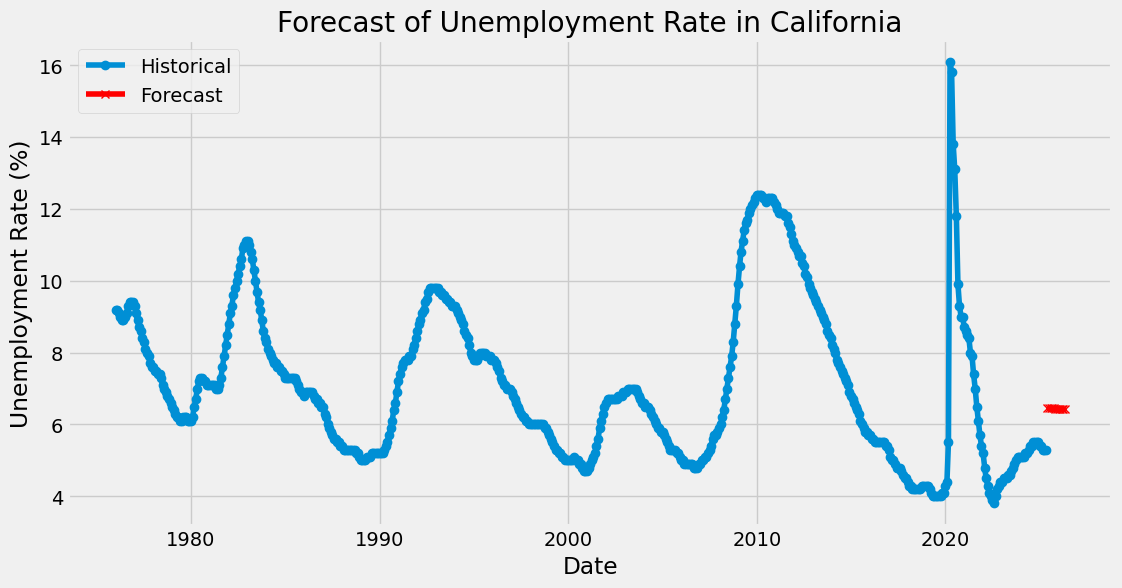

In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert Date to numeric format for regression
ca_df['Date_ordinal'] = ca_df['Date'].map(pd.Timestamp.toordinal)

# Define X and y
X = ca_df[['Date_ordinal']]
y = ca_df['Unemployment']

# Fit Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Generate future dates for next 12 months
future_dates = pd.date_range(start=ca_df['Date'].max(), periods=13, freq='MS')[1:]
future_ordinals = future_dates.map(pd.Timestamp.toordinal).to_numpy().reshape(-1, 1)

# Predict future unemployment
future_preds = model.predict(future_ordinals)

# Plot Historical and Forecasted Unemployment
plt.figure(figsize=(12,6))
plt.plot(ca_df['Date'], ca_df['Unemployment'], label='Historical', marker='o')
plt.plot(future_dates, future_preds, label='Forecast', marker='x', color='red')
plt.title(f'Forecast of Unemployment Rate in {state}')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


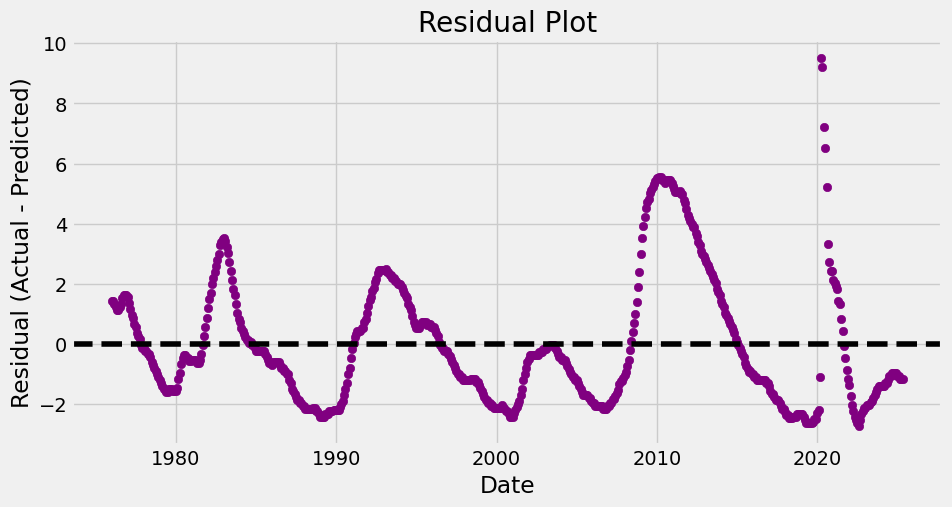

In [13]:
# Calculate predicted values on historical data
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Plot residuals
plt.figure(figsize=(10,5))
plt.scatter(ca_df['Date'], residuals, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Plot')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()


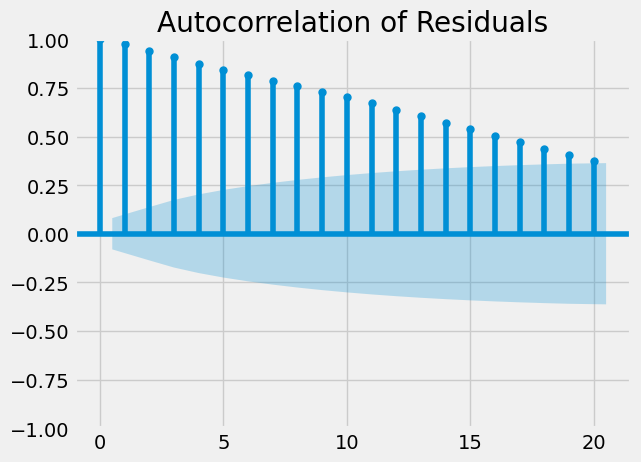

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()


In [15]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f'R-squared: {r2:.3f}')
print(f'Mean Squared Error: {mse:.3f}')


R-squared: 0.031
Mean Squared Error: 4.554


### Exploratory Analysis & Stationarity Check

To ensure the data meets the assumptions required for a more suitable modelling technique; ARIMA, we:

- Visually inspect the time series for trends or seasonality.
- Perform the Augmented Dickey-Fuller (ADF) test to formally assess stationarity.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Set datetime index again, if not already done
uemp_states.index = pd.to_datetime(uemp_states.index)

# Extract California unemployment data
ca_data = uemp_states['California'].dropna()

# Ensure it's a proper time series
ca_data = ca_data.asfreq('MS')  # Monthly Start frequency


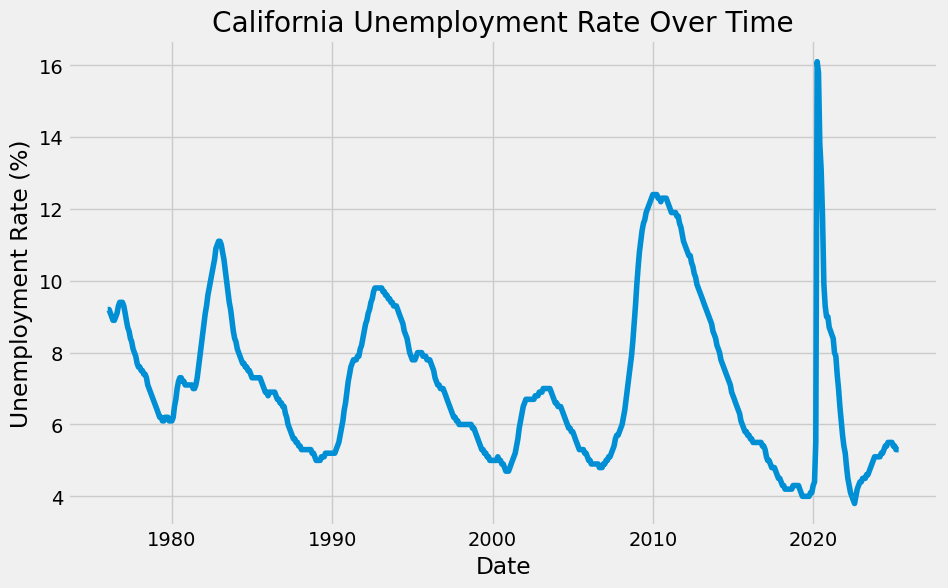

In [24]:

plt.figure(figsize=(10,6))
plt.plot(ca_data)
plt.title('California Unemployment Rate Over Time')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()


### Model Diagnostics

We perform residual diagnostics to validate the model, including:

- Residual plots to assess randomness and constant variance.
- ACF plot of residuals to check for remaining autocorrelation.
- Formal diagnostic plots to assess model adequacy.

In [25]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ca_data.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -3.2541475991452176
p-value: 0.01705669478880595


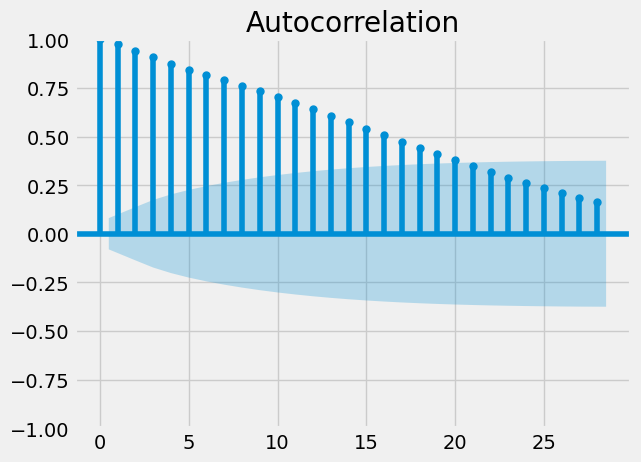

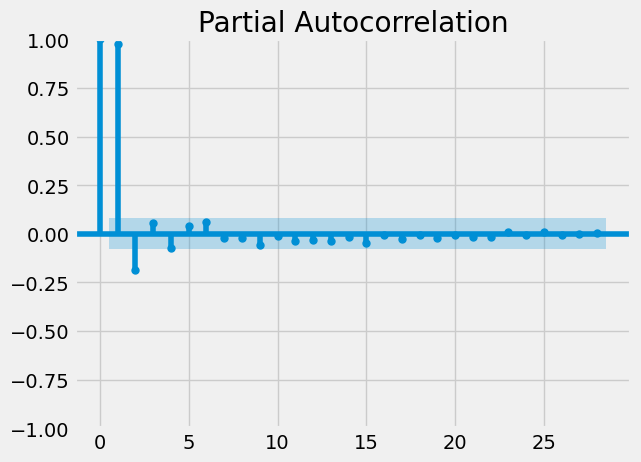

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for raw data
plot_acf(ca_data.dropna())
plt.show()

plot_pacf(ca_data.dropna())
plt.show()


### ARIMA Model Selection and Fitting

Using both visual insights and quantitative evaluation via the Akaike Information Criterion (AIC), we:

- Test different ARIMA `(p, d, q)` configurations.
- Select the model with the lowest AIC, indicating the best balance of fit and complexity.
- Fit the selected ARIMA model to the data.


In [21]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")  # Suppress warnings for clean output

# Store results
results = []

# Try p, d, q values from 0 to 2
for p in range(3):
    for d in range(2):  # Typically d is 0 or 1
        for q in range(3):
            try:
                model = ARIMA(ca_data, order=(p,d,q))
                model_fit = model.fit()
                aic = model_fit.aic
                results.append({'order': (p,d,q), 'AIC': aic})
            except:
                continue  # Skip invalid models

# Sort results by AIC
results = sorted(results, key=lambda x: x['AIC'])

# Display best models
for res in results[:5]:
    print(f"Order: {res['order']}, AIC: {res['AIC']:.2f}")


Order: (2, 1, 2), AIC: 782.24
Order: (1, 0, 1), AIC: 783.18
Order: (2, 0, 1), AIC: 783.36
Order: (1, 0, 2), AIC: 783.85
Order: (1, 1, 1), AIC: 784.49


## Forecasting and Visualization

The fitted ARIMA model is used to forecast California's unemployment rate for the next 12 months. We visualize:
- The historical unemployment trend.
- The forecasted values.
- The forecast confidence intervals.

This provides insight into the potential future trajectory of the unemployment rate.

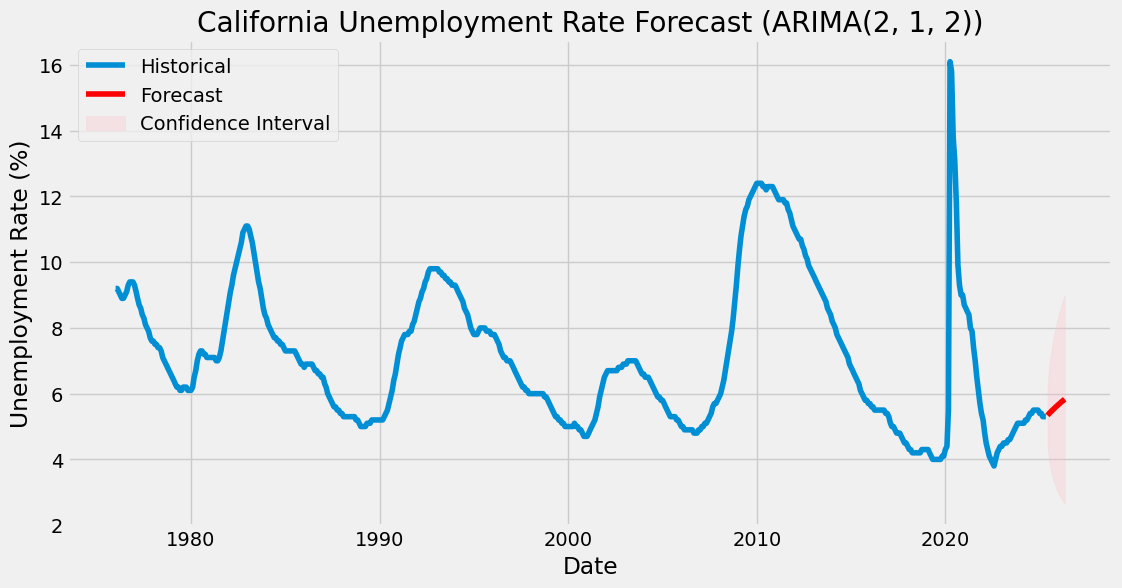

In [22]:
# Fit the best ARIMA model
best_order = (2, 1, 2)

model = ARIMA(ca_data, order=best_order)
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(ca_data, label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_mean.index, 
                 forecast_conf_int.iloc[:,0], 
                 forecast_conf_int.iloc[:,1], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title(f'California Unemployment Rate Forecast (ARIMA{best_order})')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


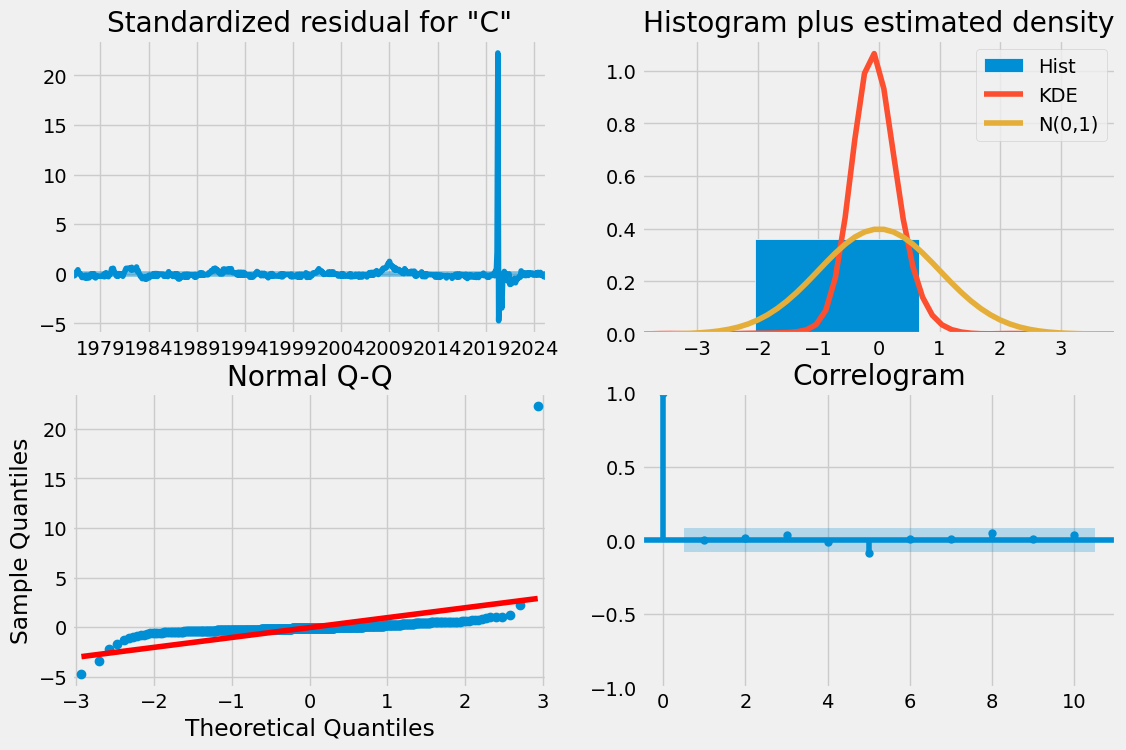

In [23]:
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()


## Conclusion

The ARIMA model provides a systematic approach to forecasting California's unemployment rate. Pre-modelling diagnostics confirm stationarity, and AIC-based model selection ensures an appropriate model choice. The resulting forecasts offer insight into future unemployment trends, with residual diagnostics indicating reasonable model performance. Potential future work includes exploring seasonal models (SARIMA) or incorporating exogenous variables to improve forecast accuracy.